In [1]:
import cv2
import numpy as np
from cv2.typing import MatLike


def filter_face(frame: MatLike) -> MatLike:
    """
    Remove faces from an image and replaces with a black box

    Parameters
    ----------
    frame : numpy.ndarray
        The image to filter

    Returns
    -------
    numpy.ndarray
        The face filtered image with faces removed
    """

    # Load the face cascade classifier
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )

    # Convert the image to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Perform face detection
    scale_factor = 1.2
    min_neighbors = 2
    faces = face_cascade.detectMultiScale(gray, scale_factor, min_neighbors)

    # Check if a face is detected
    if len(faces) > 0:
        # Get the coordinates of the face
        (x, y, w, h) = faces[0]

        # Set the region of the image that contains the face to black
        # extra black space to remove the neck and completely hide the face
        frame[
            y - 30 : y + h + 50,
            x - 10 : x + w + 10,
        ] = 0

        frame[
            y - 30 : y + h + 85,
            x + 10 : x + w - 30,
        ] = 0

    return frame


def filter_skin(frame: MatLike) -> MatLike:
    """
    Filter an image so that only the hands remain
        and the rest of the image is blacked out

    Parameters
    ----------
    frame : numpy.ndarray
        The image to filter

    Returns
    -------
    numpy.ndarray
        The filtered image
    """
    white = (255, 255, 255)
    green = (0, 255, 0)
    contour_area_min_limit = 3000

    # Convert the image to the HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define a range for skin color in HSV
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # Threshold the HSV image to get only skin colors
    mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter the contours based on their area
    hand_contours = [
        cnt for cnt in contours if cv2.contourArea(cnt) > contour_area_min_limit
    ]

    # # Draw the hand contours on the frame
    # cv2.drawContours(frame, hand_contours, -1, green, 3)

    # Create a blank black image
    hand_mask = np.zeros(frame.shape[:2], dtype="uint8")

    # Draw the hand contours on the mask
    cv2.drawContours(hand_mask, hand_contours, -1, white, thickness=cv2.FILLED)

    # Set everything outside of the hand contours to black in the original image
    frame = cv2.bitwise_and(frame, frame, mask=hand_mask)

    return frame


def filter_edges(frame: MatLike) -> MatLike:
    """
    Filter an image so that only the edges remain and dilate them for clarity

    Parameters
    ----------
    frame : numpy.ndarray
        The image to filter

    Returns
    -------
    numpy.ndarray
        The filtered image
    """

    # Convert the image to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Find the edges in the image
    lower_threshold = 25
    upper_threshold = 125
    edges = cv2.Canny(gray, lower_threshold, upper_threshold)

    # Define a kernel for dilation
    kernel = np.ones((3, 3), np.uint8)

    # Dilate the edges to make them thicker
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    dilated_edges = cv2.GaussianBlur(dilated_edges, (5, 5), 0)

    return dilated_edges


def resize_image(frame: MatLike) -> MatLike:
    """
    Resize an image to a standard size

    Parameters
    ----------
    frame : numpy.ndarray
        The image to resize

    Returns
    -------
    numpy.ndarray
        The resized image
    """

    resized_img = cv2.resize(frame, (256, 256))

    return resized_img


def apply_image_filters(frame: MatLike, resized=False) -> MatLike:
    """
    Apply all the filters to an image

    Parameters
    ----------
    frame : numpy.ndarray
        The image to filter

    resized : bool, optional
        Whether to resize the image to a standard size, by default False.
        This exists so that filters can be displayed on the original image
        size as well as the resized image size

    Returns
    -------
    numpy.ndarray
        The filtered image
    """

    face_filter = filter_face(frame)
    skin_filter = filter_skin(face_filter)
    out_img = filter_edges(skin_filter)

    if resized:
        out_img = resize_image(out_img)

    return out_img

# 2. Capture a single image

In [155]:
import cv2

capture = cv2.VideoCapture(0)
# Check if the camera is opened successfully
if not capture.isOpened():
    print("Unable to open the camera")

# Read a frame from the camera
ret, frame = capture.read()

# Check if the frame is read successfully
if not ret:
    print("Failed to read frame from the camera")

cv2.imwrite("./examples/N.jpg", frame)
print("Image saved successfully")

Image saved successfully


# 3. Example images for verification

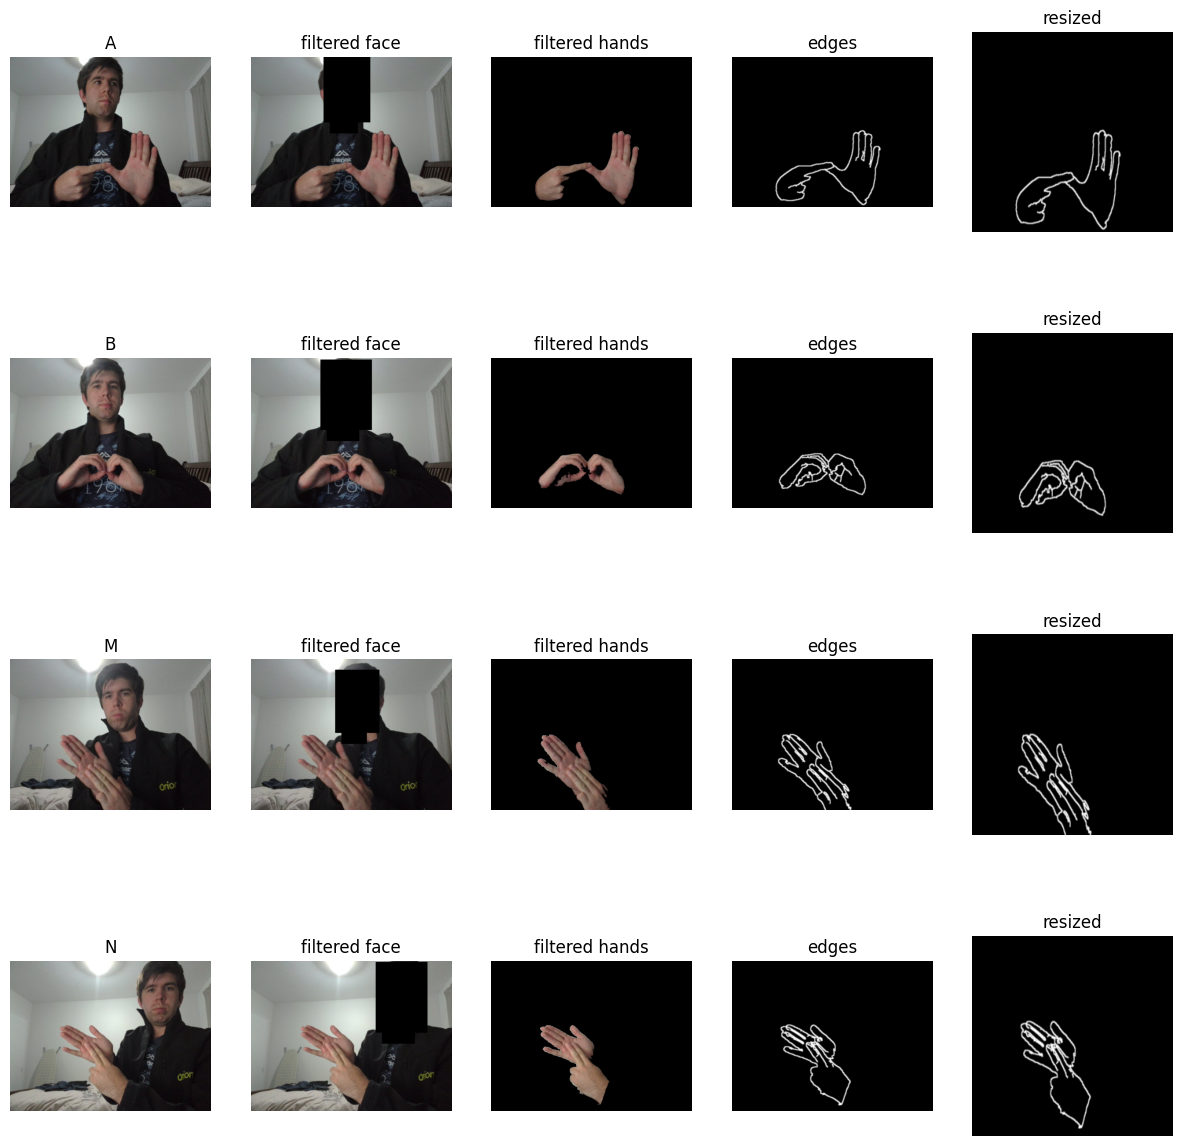

In [2]:
import matplotlib.pyplot as plt
import cv2
# from filters import *

frame_A = cv2.imread("./examples/A.jpg")
frame_B = cv2.imread("./examples/B.jpg")
frame_C = cv2.imread("./examples/M.jpg")
frame_X = cv2.imread("./examples/N.jpg")


class ImagePlotter:
    def __init__(self, rows, cols):
        self.counter = 0
        self.rows = rows
        self.cols = cols
        self.positions = [
            i for j in range(cols) for i in range(j + 1, rows * cols + 1, cols)
        ]

    def plot_image(self, name, frame):
        plt.subplot(self.rows, self.cols, self.positions[self.counter])
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(name)
        self.counter += 1


plotter = ImagePlotter(4, 5)

plt.figure(figsize=(15, 15))

plotter.plot_image("A", frame_A)
plotter.plot_image("B", frame_B)
plotter.plot_image("M", frame_C)
plotter.plot_image("N", frame_X)

frame_A = filter_face(frame_A)
frame_B = filter_face(frame_B)
frame_C = filter_face(frame_C)
frame_X = filter_face(frame_X)

plotter.plot_image("filtered face", frame_A)
plotter.plot_image("filtered face", frame_B)
plotter.plot_image("filtered face", frame_C)
plotter.plot_image("filtered face", frame_X)

frame_A = filter_skin(frame_A)
frame_B = filter_skin(frame_B)
frame_C = filter_skin(frame_C)
frame_X = filter_skin(frame_X)

plotter.plot_image("filtered hands", frame_A)
plotter.plot_image("filtered hands", frame_B)
plotter.plot_image("filtered hands", frame_C)
plotter.plot_image("filtered hands", frame_X)

frame_A = filter_edges(frame_A)
frame_B = filter_edges(frame_B)
frame_C = filter_edges(frame_C)
frame_X = filter_edges(frame_X)

plotter.plot_image("edges", frame_A)
plotter.plot_image("edges", frame_B)
plotter.plot_image("edges", frame_C)
plotter.plot_image("edges", frame_X)

frame_A = resize_image(frame_A)
frame_B = resize_image(frame_B)
frame_C = resize_image(frame_C)
frame_X = resize_image(frame_X)

plotter.plot_image("resized", frame_A)
plotter.plot_image("resized", frame_B)
plotter.plot_image("resized", frame_C)
plotter.plot_image("resized", frame_X)

plt.xlabel("")

plt.axis("off")
plt.show()

# 4. Live run of filtered image for testing

In [83]:
import cv2

# Open the video source or camera
capture = cv2.VideoCapture(0)

# Check if the video source or camera is opened successfully
if not capture.isOpened():
    print("Unable to open the video source or camera")

# Loop through the frames
while True:
    # Read a frame from the video source or camera
    ret, frame = capture.read()

    filtered_frame = apply_image_filters(frame)

    # Check if the frame is read successfully
    if not ret:
        print("Failed to read frame from the video source or camera")
        break

    # Perform operations on the frame
    # For example, you can display the frame
    cv2.imshow("Frame", filtered_frame)

    # Exit the loop if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release the video source or camera and close all windows
capture.release()
cv2.destroyAllWindows()

# 5. Collect training data

In [5]:
collection_classes = [
    # "my",
    "name",
    "hello",
    "A",
    "B",
    "C",
    "M",
    "N",
    "X"
]


DATA_PATH = "./testing_data/"

CSV_FILE = "./testing_data/training_data.csv"

capture_frames = 20
n_sequences = 50
capture_interval = 1.5

In [82]:
import cv2
import time
import os
import pandas as pd

# (0) in VideoCapture is used to connect to your computer's default camera
capture = cv2.VideoCapture(0)

# Initializing current time and previous time for calculating the FPS
previousTime = 0
currentTime = 0


previous_capture_time = time.time()
capturing = False


current_class = 0
sequences_captured = 0
capture_frame = 0

paused = -1

csv_file = open(CSV_FILE, "w")

while capture.isOpened():
    # capture frame by frame
    ret, frame = capture.read()

    # resizing the frame for better view
    image = cv2.resize(frame, (800, 600))

    # Converting the from BGR to RGB
    filtered_image = apply_image_filters(image.copy(), False)
    resized_image = resize_image(filtered_image)

    if capturing:
        # Making predictions using holistic model
        # To improve performance, image is marked as not writeable to pass by reference.

        folder_path = (
            f"{DATA_PATH}/{collection_classes[current_class]}/{sequences_captured}"
        )

        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        flattened_image = resized_image.flatten()

        if capture_frame > 0:
            # cv2.imwrite(folder_path + f"/{capture_frame}.jpg", image)

            csv_file.write(
                f"{current_class},{','.join([str(pixel) for pixel in flattened_image])}\n"
            )

        capture_frame += 1

        if capture_frame == capture_frames:
            capturing = False
            previous_capture_time = time.time()
            capture_frame = 0
            sequences_captured += 1

            if sequences_captured == n_sequences:
                sequences_captured = 0
                current_class += 1
                if current_class == len(collection_classes):
                    print("Data collection complete")
                    break

    if not capturing:
        filtered_image = cv2.cvtColor(filtered_image, cv2.COLOR_RGB2BGR)
        if paused == 1:
            cv2.putText(
                filtered_image,
                "paused, press p to continue",
                (215, 350),
                cv2.FONT_HERSHEY_COMPLEX,
                1,
                (0, 255, 0),
                2,
            )
        else:
            cv2.putText(
                filtered_image,
                "Get ready to capture",
                (225, 350),
                cv2.FONT_HERSHEY_COMPLEX,
                1,
                (0, 255, 0),
                2,
            )
            if time.time() - previous_capture_time >= capture_interval:
                capturing = True

    # Calculating the FPS
    currentTime = time.time()
    fps = 1 / (currentTime - previousTime)
    previousTime = currentTime

    # Displaying FPS on the image
    cv2.putText(
        filtered_image,
        str(int(fps)) + " FPS",
        (10, 70),
        cv2.FONT_HERSHEY_COMPLEX,
        1,
        (0, 255, 0),
        2,
    )

    cv2.putText(
        filtered_image,
        "capturing "
        + str(sequences_captured + 1)
        + " of "
        + str(n_sequences)
        + ' for "'
        + str(collection_classes[current_class])
        + '"'
        + " dclass " 
        + str(current_class + 1) 
        + " of " 
        + str(len(collection_classes)),
        (10, 575),
        cv2.FONT_HERSHEY_COMPLEX,
        1,
        (0, 255, 0),
        2,
    )

    # cv2.putText(
    #     filtered_image,
    #     "class " + str(current_class + 1) + " of " + str(len(collection_classes)),
    #     (525, 575),
    #     cv2.FONT_HERSHEY_COMPLEX,
    #     1,
    #     (0, 255, 0),
    #     2,
    # )

    # Display the resulting image
    cv2.imshow("Facial and Hand Landmarks", filtered_image)

    # Enter key 'q' to break the loop
    key = cv2.waitKey(5) & 0xFF

    quit_key = ord("q")
    paused_key = ord("p")

    if key == quit_key:
        break
    elif key == paused_key:
        paused *= -1
        previous_capture_time = time.time()


csv_file.close()

capture.release()
cv2.destroyAllWindows()

# 6. Load the data into dataloaders

In [55]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


class HandDataset(Dataset):
    def __init__(self, data):
        self.labels = data[:, :, 0][:, 0]  # Extract the label column
        self.data = data[:, :, 1:]  # Exclude the data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {
            "data": torch.tensor(self.data[idx], dtype=torch.float32),
            "label": torch.tensor(
                self.labels[idx], dtype=torch.float32
            ),  # .reshape(1),
        }
        return sample


# Load the processed data from the CSV file
processed_data = np.loadtxt(CSV_FILE, delimiter=",")

image_size = 256 * 256

reshaped_data = processed_data.reshape(-1, capture_frames, image_size + 1)

# Create a dataset from the processed data
dataset = HandDataset(reshaped_data)

# Get the indices of the data and split them
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.75, random_state=42)

# Create subsets based on the split indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

training_batch_size = 100
test_batch_size = 25

# Create data loaders for training and testing sets
train_dataloader = DataLoader(
    train_dataset, batch_size=training_batch_size, shuffle=True
)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
# Loop through each batch in the training set
for batch in train_dataloader:
    data = batch["data"]
    label = batch["label"]
    print(label)
    print(data.shape)
    print(label.shape)

tensor([0., 0., 1., 2., 2., 3., 1., 1., 3., 3., 0., 3., 1., 3., 0., 1., 3., 1.,
        3., 2., 1., 2., 0., 1., 1., 0., 2., 2., 1., 3., 3., 1., 2., 3., 2., 3.,
        0., 1., 1., 1., 1., 0., 3., 2., 2., 3., 2.])
torch.Size([47, 20, 65536])
torch.Size([47])


# 7. Define the LSTM and dataset models and parameters

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset


# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_classes = [
    "hello",
    "A",
    "B",
    "C",
    # "no hands" "my",
    # "name",
    # "hello",
    # "A",
    # "B",
    # "C",
    # "M",
    # "N",
    # "X"
    # "D": 2,
    # "A": 2,
    # "N": 2,
    # "I": 2,
    # "E": 2,
    # "L": 2,
]

input_size = 256 * 256
hidden_size = 128
num_layers = 2
num_classes = len(training_classes)


# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         # Set initial hidden and cell states
#         # print(x.shape)
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

#         # Forward propagate LSTM
#         out, _ = self.lstm(x, (h0, c0))

#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         return out


# # LSTM Model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(LSTMModel, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.fc(out[:, -1, :])  # Only take the output from the last time step
#         return out


class LSTMModel(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.2
    ):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout_prob,
            bidirectional=True,
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply by 2 for BiLSTM

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])  # Only take the output from the last time step
        return out


class FeatureDataset(Dataset):
    def __init__(self, keypoints, labels):
        self.keypoints = keypoints
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.keypoints[idx]), torch.LongTensor(
            [self.labels[idx]]
        )

# 8. Train the LSTM model

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Load your CSV file without a header
df = pd.read_csv(CSV_FILE, header=None)

# Extract labels and keypoint data columns
labels = df.iloc[:, 0].astype("category").cat.codes.values
keypoints = df.iloc[:, 1:]

# Normalize keypoints if needed (you might want to customize this based on your data)
scaler = StandardScaler()
keypoints_normalized = scaler.fit_transform(keypoints)

# Reshape the data into sequences of 30 frames
keypoints_reshaped = keypoints_normalized.reshape(
    -1, capture_frames, len(keypoints.columns)
)

# Ensure the number of samples in keypoints_reshaped matches the number of labels
num_samples = min(len(labels), len(keypoints_reshaped))
keypoints_reshaped = keypoints_reshaped[:num_samples]
labels = labels[::capture_frames]

# Split the data into training and validation sets
keypoints_train, keypoints_val, labels_train, labels_val = train_test_split(
    keypoints_reshaped, labels, test_size=0.25, random_state=42
)


# Create instances of the dataset for training and validation
train_dataset = FeatureDataset(keypoints_train, labels_train)
val_dataset = FeatureDataset(keypoints_val, labels_val)

# Create DataLoader instances
training_batch_size = 75
validation_batch_size = 25
train_loader = DataLoader(train_dataset, batch_size=training_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=validation_batch_size, shuffle=False)

# Set model parameters
# input_size = len(keypoints.columns)  # Number of keypoints in each frame
# hidden_size = 128
# num_layers = 2
# num_classes = len(df.iloc[:, 0].unique())  # Number of unique classes

# Instantiate the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for data, labels in val_loader:
            outputs = model(data)
            preds = torch.argmax(outputs, dim=1)
            # print(labels.squeeze(1))
            # print(preds)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy on the validation set
    accuracy = accuracy_score(all_labels, all_preds)
    print(
        f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.4f}"
    )

torch.save(model.state_dict(), "./models/lstm_image_rnn_01_25_epoch.pth")

Epoch [1/25], Loss: 1.3881, Validation Accuracy: 0.3750
Epoch [2/25], Loss: 1.2687, Validation Accuracy: 0.4792
Epoch [3/25], Loss: 1.1911, Validation Accuracy: 0.6458
Epoch [4/25], Loss: 1.1149, Validation Accuracy: 0.7083
Epoch [5/25], Loss: 1.0668, Validation Accuracy: 0.7917
Epoch [6/25], Loss: 0.9994, Validation Accuracy: 0.8333
Epoch [7/25], Loss: 0.9350, Validation Accuracy: 0.8542
Epoch [8/25], Loss: 0.8870, Validation Accuracy: 0.8542
Epoch [9/25], Loss: 0.8286, Validation Accuracy: 0.8542
Epoch [10/25], Loss: 0.7777, Validation Accuracy: 0.8542
Epoch [11/25], Loss: 0.7228, Validation Accuracy: 0.8542
Epoch [12/25], Loss: 0.6767, Validation Accuracy: 0.8958
Epoch [13/25], Loss: 0.6062, Validation Accuracy: 0.8958
Epoch [14/25], Loss: 0.5419, Validation Accuracy: 0.8958
Epoch [15/25], Loss: 0.4910, Validation Accuracy: 0.8958
Epoch [16/25], Loss: 0.4611, Validation Accuracy: 0.9375
Epoch [17/25], Loss: 0.3921, Validation Accuracy: 0.9792
Epoch [18/25], Loss: 0.3600, Validation 

RuntimeError: Parent directory ../models does not exist.

# 9. Visualise labels and predictions from training dataset

In [4]:
print(training_classes)

for data, labels in val_loader:
    outputs = model(data)
    preds = torch.argmax(outputs, dim=1)

    print(labels)
    print(preds)

['hello', 'A', 'B', 'C']


NameError: name 'val_loader' is not defined

# 10. Load the model and test live

In [4]:
import cv2
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import time
import torch.nn as nn


# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# load the model
# Set model parameters
# input_size = 256 * 256
# hidden_size = 128
# num_layers = 2
# num_classes = len(training_classes)
model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
model.load_state_dict(torch.load("./models/lstm_image_rnn_01.pth"))
model.eval()

SCALER = StandardScaler()
ENCODER = LabelEncoder()

device = torch.device("cpu")  # "cuda" if torch.cuda.is_available() else "cpu")

frame_buffer = []
output_buffer = []


# Function to process the frame and make predictions
def process_frame(image):
    global frame_buffer, output_buffer

    flattened_image = image.flatten()

    frame_buffer.append(flattened_image)

    # Maintain only the last 5 frames in the buffer
    if len(frame_buffer) >= capture_frames:
        frame_buffer = frame_buffer[-capture_frames:]

    if len(frame_buffer) == capture_frames:
        # df = pd.DataFrame(frame_buffer)

        # input_tensor = torch.tensor(df, dtype=torch.float32)
        # input_tensor = input_tensor.unsqueeze(0).to(device)
        values = np.array(frame_buffer)
        input_tensor = torch.tensor(values, dtype=torch.float32)
        input_tensor = input_tensor.view(1, capture_frames, -1).to(
            device
        )  # Reshape the input tensor

        with torch.no_grad():
            output = model(input_tensor)
            output_buffer.append(output)

            _, predicted_class = torch.max(output, 1)

            return training_classes[predicted_class]


displayed_prediction = None
previousTime = 0
previousTime_1 = 0

# Open the video capture
capture = cv2.VideoCapture(0)

# Loop through the frames
while capture.isOpened():
    # Read the frame from the video capture
    ret, image = capture.read()

    # resizing the frame for better view
    image = cv2.resize(image, (800, 600))

    filtered_image = apply_image_filters(image, False)

    # Process the frame and make predictions
    prediction = process_frame(filtered_image)

    visual_image = cv2.cvtColor(filtered_image, cv2.COLOR_GRAY2RGB)

    if prediction is not None:
        # Draw the predictions on the frame (if required)
        cv2.putText(
            visual_image,
            f"Prediction: {prediction}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2,
        )

    # Calculating the FPS
    fps = 1 / (time.time() - previousTime)
    previousTime = time.time()

    # Displaying FPS on the image
    cv2.putText(
        visual_image,
        str(int(fps)) + " FPS",
        (10, 70),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2,
    )

    # Display the image
    cv2.imshow("Frame", visual_image)

    # Check for key press to exit the loop
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break


# Release the video capture and close the window
capture.release()
cv2.destroyAllWindows()

C:\Users\danie\AppData\Local\Temp\ipykernel_15284\1994951231.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


NameError: name 'capture_frames' is not defined